In [2]:
from asyncio.format_helpers import _format_callback_source
import numpy as np
from scipy import optimize as opt
from scipy import linalg as la
from matplotlib import pyplot as plt

# Problem 1
def steepest_descent(f, Df, x0, tol=1e-5, maxiter=100):
    """Compute the minimizer of f using the exact method of steepest descent.

    Parameters:
        f (function): The objective function. Accepts a NumPy array of shape
            (n,) and returns a float.
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        ((n,) ndarray): The approximate minimum of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    converged = False          #keep track of whether the algorithm converged or not
    iters = 0

    phi = lambda a: f(x0 - a*Df(x0).T)       #define the function phi to find ak

    for i in range(maxiter):
        a0 = opt.minimize_scalar(phi).x         #find the argmin of phi to find the step size
        x1 = x0 - (a0 * Df(x0).T)               #use exact gradient descent
        iters += 1

        if np.max(np.abs(Df(x0))) < tol:        #see whether converged
            converged = True
            break

        x0 = x1

    return x1, converged, iters

def test1():
    f = lambda x: x[0]**4 + x[1]**4 + x[2]**4
    Df = lambda x: np.array([4*x[0]**3, 4*x[1]**3, 4*x[2]**3])
    print(steepest_descent(f, Df, x0 = np.array([1, 1, 2]), tol=1e-10))
test1()

(array([-2.23096122e-05, -2.23096122e-05, -4.46192243e-05]), True, 10)


In [3]:
# Problem 2
def conjugate_gradient(Q, b, x0, tol=1e-4):
    """Solve the linear system Qx = b with the conjugate gradient algorithm.

    Parameters:
        Q ((n,n) ndarray): A positive-definite square matrix.
        b ((n, ) ndarray): The right-hand side of the linear system.
        x0 ((n,) ndarray): An initial guess for the solution to Qx = b.
        tol (float): The convergence tolerance.

    Returns:
        ((n,) ndarray): The solution to the linear system Qx = b.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    n = Q.ndim          #get the dimension of Q
    r0 = Q @ x0 - b     #define our initial r and d
    d0 = -r0
    k = 0
    iters = 0
    converged = False           #keep track of whether converges

    while la.norm(r0) >= tol and k < n:
        ak = (r0 @ r0) / (d0 @ Q @ d0)
        x1 = x0 + ak * d0
        r1 = r0 + ak * Q @ d0
        b1 = (r1 @ r1) / (r0 @ r0)        #use the conjugate gradient descent algorithm from the lab file
        d1 = -r1 + b1*d0

        x0 = x1
        d0 = d1
        r0 = r1
        k += 1

    if iters <= n:              #check to see if converged
        converged = True
    return x1, converged, k

def test2():
    Q = np.array([[2, 0], [0, 4]])
    b = np.array([1, 8])
    x0 = np.array([1, 3])
    f = lambda x: x[0]**2 + 2*x[1]**2 - x[0] - 8*x[1]
    Df = lambda x: np.array([2*x[0] - 1, 4*x[1] - 8])
    print(conjugate_gradient(Q, b, x0))
    print(steepest_descent(f, Df, x0))
test2()

(array([0.5, 2. ]), True, 2)
(array([0.5000003 , 2.00000054]), True, 8)


In [4]:
# Problem 3
def nonlinear_conjugate_gradient(f, df, x0, tol=1e-5, maxiter=100):
    """Compute the minimizer of f using the nonlinear conjugate gradient
    algorithm.

    Parameters:
        f (function): The objective function. Accepts a NumPy array of shape
            (n,) and returns a float.
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        tol (float): The stopping tolerance.
        maxiter (int): The maximum number of iterations to compute.

    Returns:
        ((n,) ndarray): The approximate minimum of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    x1 = x0
    r0 = -df(x0).T                      #complete our first iteration that is a little different outside the loop
    d1 = r0
    converged = False
    phi = lambda a: f(x1 + a*d1)        #define our function that we will minimize to find the step size
    a0 = opt.minimize_scalar(phi).x
    x1 = x1 + a0*d1
    k = 1

    while la.norm(r0) >= tol and k < maxiter:         #continue until we have done the max iterations or until the gradient of the objective function is sufficiently small
        r1 = -df(x1).T
        b1 = (r1 @ r1) / (r0 @ r0)
        d1 = r1 + b1*d1
        a1 = opt.minimize_scalar(phi).x              #use the algorithm provided in the lab file for nonlinear conjugate gradient
        x1 = x1 + a1 * d1
        k+=1
        r0 = r1

    if k <= maxiter:                      #check to see if the algorithm converged or not
        converged = True

    return x1, converged, k

def test3():
    def f(x):
        return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

    def Df(x):
        return np.array([400*x[0]*(x[0]**2 - x[1]) + 2*x[0] - 2, -200*x[0]**2 + 200*x[1]])
    x0 = np.array([10, 10])
    print(nonlinear_conjugate_gradient(f, Df, x0, maxiter=1000))
test3()

(array([0.99999713, 0.99999427]), True, 308)


In [5]:
# Problem 4
def prob4(filename="linregression.txt",
          x0=np.array([-3482258, 15, 0, -2, -1, 0, 1829])):
    """Use conjugate_gradient() to solve the linear regression problem with
    the data from the given file, the given initial guess, and the default
    tolerance. Return the solution to the corresponding Normal Equations.
    """
    data = np.loadtxt(filename)       #load the data

    nrows, ncol = np.shape(data)

    A = np.hstack((np.ones(nrows).reshape(-1, 1), data[:, 1:]))      #create the matrix A involved in linear least squares 
    f = data[:, 0]                                                   #create matrix b for linear least squares

    Q = A.T @ A                #calculate the matrix and vector needed for the least squares system to find best parameters
    b = A.T @ f

    return conjugate_gradient(Q, b, x0)[0]
prob4()

array([-3.48225800e+06,  1.49999657e+01, -3.61956021e-02, -2.00075719e+00,
       -1.00080566e+00, -4.85249563e-02,  1.82899902e+03])

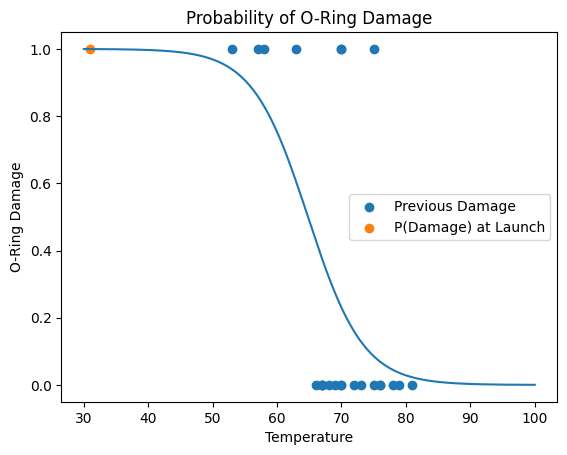

0.999609671069125

In [6]:
# Problem 5
class LogisticRegression1D:
    """Binary logistic regression classifier for one-dimensional data."""

    def fit(self, x, y, guess):
        """Choose the optimal beta values by minimizing the negative log
        likelihood function, given data and outcome labels.

        Parameters:
            x ((n,) ndarray): An array of n predictor variables.
            y ((n,) ndarray): An array of n outcome variables.
            guess (array): Initial guess for beta.
        """
        m = len(x)          #calculate our m
        log_lik = lambda b: np.sum([np.log(1 + np.exp(-(b[0] + b[1]*x[i]))) + (1 - y[i])*(b[0] + b[1]*x[i]) for i in range(m)])   #define negative log function as given
        b_min = opt.fmin_cg(log_lik, guess, disp=False)      #find the minimizer of the legative log function
        self.b0 = b_min[0]             #save the minimizing entries as attributes
        self.b1 = b_min[1]

    def predict(self, x):
        """Calculate the probability of an unlabeled predictor variable
        having an outcome of 1.

        Parameters:
            x (float): a predictor variable with an unknown label.
        """
        sigma = 1 / (1 + np.exp(-(self.b0 + self.b1*x)))      #calculate the value of sigma
        self.sigma = sigma


# Problem 6
def prob6(filename="challenger.npy", guess=np.array([20., -1.])):
    """Return the probability of O-ring damage at 31 degrees Farenheit.
    Additionally, plot the logistic curve through the challenger data
    on the interval [30, 100].

    Parameters:
        filename (str): The file to perform logistic regression on.
                        Defaults to "challenger.npy"
        guess (array): The initial guess for beta.
                        Defaults to [20., -1.]
    """
    domain = np.linspace(30, 100, 500)           #create our domain
    data = np.load(filename)        #load the data
    x = data[:, 0]
    y = data[:, 1]

    shuttle = LogisticRegression1D()
    shuttle.fit(x, y, guess)           #find the optimal beta values for our data and guess
    shuttle.predict(domain)            #predict the probability of damage over our domain

    plt.plot(domain, shuttle.sigma)    #plot the probability of o ring damage versus temperature over domain
    shuttle.predict(31)                #predict the probability of o ring damage at 31 degrees
    if_prevent = shuttle.sigma
    plt.scatter(x, y, label="Previous Damage")       #plot the previous damage data points
    plt.scatter(31, if_prevent, label="P(Damage) at Launch")    #plot the probability of o ring damage at 31 degrees
    plt.title("Probability of O-Ring Damage")
    plt.ylabel("O-Ring Damage")
    plt.xlabel("Temperature")
    plt.legend(loc="center right")
    plt.show()

    return if_prevent
prob6()